# Age of infection simulation

In [1]:
from pathlib import Path
from pprint import pprint
import yaml

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [18, 6]
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'

path_data = Path("../data/")

### all my categories
* Medical definitions for mild, moderate, severe, need respirator?
    - data report in MOH telegram: respirator number is included in severe number
    - mild can be either at home or at hospital. meaning this category is very broad
* Reality:
    - unsusceptiple
    - susceptible > exposed > symptomatic  > [moderate-severe, need-respirator] > [dead, recoverred/immune] #loosely defined
* What people do? ..... moderate-severe : hospitalization,  need-respirator : respirator
* What people think?
    - confirmed / detected [confirmed_symptoms, confirmed_PCR, confirmed_antibodies]
    - confirmed is an estimation of exposed or of symptomatic
    - timeline: exposure_t, symptomatic_t, test_t, test_result_t
    - testing scenarios:
        * random tests: person-test
        * symptomatic - any test
        * contact of confirmed - bio test

* data I have:
    - look at some raw data. understand what it means
        - respirated ~ 2/3 * severe
        - hospitalized ~ 3 * (moderate + severe)
    - some of the distributions of time delays between stages
    - new_confirmed(t)
        - I can probably work hard and perform a backwards derivation: new_confirmed(t) > symptomatic(t) > exposed(t)
            - Approach 1: deconvolution
            - Approach 2: approximation
            - Approach 3: dig further in epidemiological investigations (better data)
    - moderate-severe_tot(t)
    - critical_tot(t)
    - recovery_tot(t)
    - mild_tot(t)
    - total_cases(t)
    - tests_(t), tests_results(t)
        - it's not that easy to calculate moderate_severe(t), critical(t). they move between the stages. some recover.
        - reasonable approx: all the new cases are mild cases (symptomatic), then the overflow of mild: the part that doesn't become serious-severe goes to recovery, the other part goes to serious-severe. their overflow splits between recovery and critical, their overflow splits between recovery and dead
        - or we take into consideration that these numbers are very noisy anyway, and just diff
    - ~hospitalized(t) (fetch from Gartner graph)
    - ~need_respirator(t) (fetch from Gartner graph)
    - dead(t)
* model
* which data?

* Gartner assumptions:
    - All symptomatic are detected, with a time delay distribution.
    - confirmed_exposed_ratio parameter
    - they probably assume exposed(t) = confirmed(t) / confirmed_exposed_ratio at least for initial conditions

## decision step 1:
* do whatever they do. after that change, parameters, equations
* use

## Next steps:
* create data to run on
    - diff tsvikas data
    - fetch manually
* present data on graph
* run fit once
    - Guy Ishay, mandelker
    - read briefly on sp.optimize.curve_fit
    - lm_fit
* load and display current predictions of gartner
* try to reproduce their model. even not precisely.
* remember I can also use the R(t)


## running predictions using their params and compare

## then adaptations:
* 1
* 2
* Population is devided to 2 sub groups: one standard, protected. The protected is affected but not affecting.
    - The time propagation of the standard (susceptible, exposed) is as usual
    - The protected has a narrow bridge to the world: either an old person with a caretaker that hardly goes out, or with a caretaker that hardly goes in. In any case, the chances of the protected person becoming infected depends on the chances of his caretaker becoming infected * becoming_infected_coefficient that represents the narrow bridge (low interaction with good hygene)

### next steps
1. initial conditions: 1-10 march, shift back, factor for hidden: OK
1. use R by sigmoid function from correct date : OK, possible
1. run prediction again : works. I leave aside the comparison. their predictions for april are without the sigmoid anyway
1. plugin: protecting the elders
    1. write model OK
    1. which parameters? make sure I can get them:
        1. CFR by age group: from my team - waiting for
        1. interactions ratio. Estimate form team - waiting for
    1. write design: OK
    1. code : OK
    1. clean the code a bit + make it run. time for  new notebook
1. fitting only to hospitalization === moderate severe data

# transitions parameters

In [116]:
from collections import OrderedDict


from enum import IntEnum
class Status(IntEnum):
    susceptible = 1
    exposed = 2
    symptomatic = 3
    moderate_severe = 4
    respirated = 5
    dead = 6
    recover = 7

from collections import namedtuple
SourceDestination = namedtuple('SourceDestination', 'source destination')
TransitionAttributes = namedtuple('TransitionAttribues', 'p impulse_response')
TransitionAttributes.__new__.__defaults__ = (None, None)

## conditional probability between stages

## time delays between stages: impulse responses

In [2]:
def gamma_impulse_response(mean, std, x=None, normalization='sum1'):
    if x is None:
        x = np.arange(1, 1 + mean + 2 * std)
    gamma = sp.stats.gamma(mean ** 2 / std ** 2, 0, std ** 2 / mean)
    impulse_response = pd.Series(index=pd.TimedeltaIndex(x, unit='day'), data=gamma.pdf(x))
    if normalization == 'sum1':
        impulse_response = impulse_response / impulse_response.sum()
    else:
        raise ValueError('which normalization?')
    #print(impulse_response)
    return impulse_response


def delayed_uniform_impulse_response(t1, t2, x=None, normalization='sum1'):
    if x is None:
        x = np.arange(1, t2 + 1)
    uniform = sp.stats.uniform(loc=t1+1, scale=(t2-t1))
    impulse_response = pd.Series(index=pd.TimedeltaIndex(x, unit='day'), data=uniform.pdf(x))
    if normalization == 'sum1':
        impulse_response = impulse_response / impulse_response.sum()
    else:
        raise ValueError('which normalization?')
    #print(impulse_response)
    return impulse_response
    

conditinal_probability_exposed_to_symptoms = 0.5 #Gartner arbitrary
conditional_probability_symptoms_to_moderate_severe = 0.066
conditional_probability_symptoms_to_respirator = 0.023
conditional_probability_symptoms_to_death = 0.0092

In [138]:
# not a transition
generation_time_mean = 4
generation_time_std = 2
infection_impulse_response = gamma_impulse_response(generation_time_mean, generation_time_std)#, np.arange(1, 1 + generation_time_mean + 2 * generation_time_std))

leg_exposed_to_symptoms_mean = 5.5
leg_exposed_to_symptoms_std = 2.3

leg_symptom_to_moderate_severe_mean = 8.4
leg_symptom_to_moderate_severe_std = 4.9

leg_symptom_to_respirator_mean = 9.9
leg_symptom_to_respirator_std = 5.6

leg_symptom_to_dead_mean = 10.9
leg_symptom_to_dead_std = 6

#x = np.arange(1, T + 1)
exposed_to_symptoms_ir = gamma_impulse_response(leg_exposed_to_symptoms_mean, leg_exposed_to_symptoms_std, np.arange(1, 1 + leg_exposed_to_symptoms_mean + 2 * leg_exposed_to_symptoms_std))
symptoms_to_moderate_severe_ir = gamma_impulse_response(leg_symptom_to_moderate_severe_mean, leg_symptom_to_moderate_severe_std)
symptoms_to_respirator_ir = gamma_impulse_response(leg_symptom_to_respirator_mean, leg_symptom_to_respirator_std)
symptoms_to_death_ir = gamma_impulse_response(leg_symptom_to_dead_mean, leg_symptom_to_dead_std)

## recovering IR

symptoms_to_recover_range = (7, 14)
moderate_severe_to_recover_range = (14, 28)
respirator_to_recover_range = (7, 14) # obviously wrong data, compare to moderate_severe, but good enough for now

symptoms_to_recover_ir = delayed_uniform_impulse_response(*symptoms_to_recover_range)
moderate_severe_to_recover_ir = delayed_uniform_impulse_response(*moderate_severe_to_recover_range)
respirator_to_recover_ir = delayed_uniform_impulse_response(*respirator_to_recover_range)



In [139]:
transitions = OrderedDict({
    SourceDestination(Status.exposed, Status.symptomatic) : TransitionAttributes(p=0.5, impulse_response=gamma_impulse_response(5.5, 2.3)),
    SourceDestination(Status.symptomatic, Status.moderate_severe) : TransitionAttributes(p=0.066, impulse_response=gamma_impulse_response(8.4, 4.9)),
    SourceDestination(Status.symptomatic, Status.respirated): TransitionAttributes(p=0.023, impulse_response=gamma_impulse_response(9.9, 5.6)),
    SourceDestination(Status.symptomatic, Status.dead): TransitionAttributes(p=0.0092, impulse_response=gamma_impulse_response(10.9, 6)),
})


In [140]:
transitions.update({
    SourceDestination(Status.symptomatic, Status.recover) : TransitionAttributes(p=1-0.066, impulse_response=delayed_uniform_impulse_response(7, 14)),
    SourceDestination(Status.moderate_severe, Status.recover) : TransitionAttributes(p=(0.066-0.023)/0.066, impulse_response=delayed_uniform_impulse_response(14, 28)),
    SourceDestination(Status.respirated, Status.recover) : TransitionAttributes(p=(0.023 - 0.0092)/0.023, impulse_response=delayed_uniform_impulse_response(7, 14)),
})

In [137]:
[tp.p for k, tp in transitions.items()]

[0.5, 0.066, 0.023, 0.0092, 0.9339999999999999, 0.6515151515151515, 0.6]

### different design

setup categories enum
setup named tuples
define interesting transitions by order
#transitions_list = [(), .....]
#probabilities dict
dict ir params
transitions dict probabilities and irs
#transitions = {(exposed, symptomatic) : (), (symptomatic, other), ...., (other, recover)}



dynamics:
setup

time propagation exposed susceptible

dynamics init [levels = patient (categories), stat: (new, net_delta, active)]
transitions_daily init [levels = source, dest]


for source_dest, params in transitions.items():
    assert source_dest.source < source_dest.dest
    source, dest = source_dest.source.name, source_dest.dest.name
    transitions_daily[source_dest.source, source_dest.dest] = params.p * convolve...(dynamics[source, new], params.ir)
    create columns if necessary
    dynamics[dest, new] += ....

for category in list(Status):
    dynamics[s, net_delta] = dynamics[s, new] - transitions_daily.xs(s, level='source', axis=1)

1 days    0.063110
2 days    0.185734
3 days    0.230606
4 days    0.201091
5 days    0.144487
6 days    0.091850
7 days    0.053657
8 days    0.029465
dtype: float64

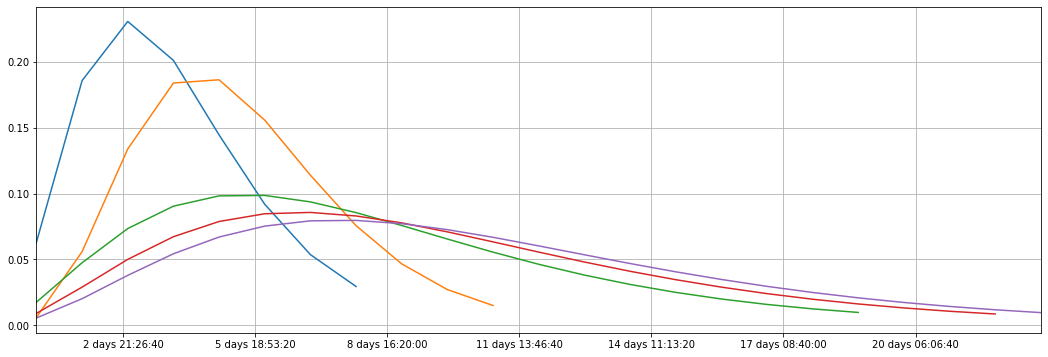

In [115]:
fig, ax = plt.subplots() 
infection_impulse_response.plot(ax=ax)
exposed_to_symptoms_ir.plot(ax=ax)
symptoms_to_moderate_severe_ir.plot(ax=ax)
symptoms_to_respirator_ir.plot(ax=ax)
symptoms_to_death_ir.plot(ax=ax)
#pd.Series(index=x, data=gamma.pdf(x)).plot()

#infection_impulse_response

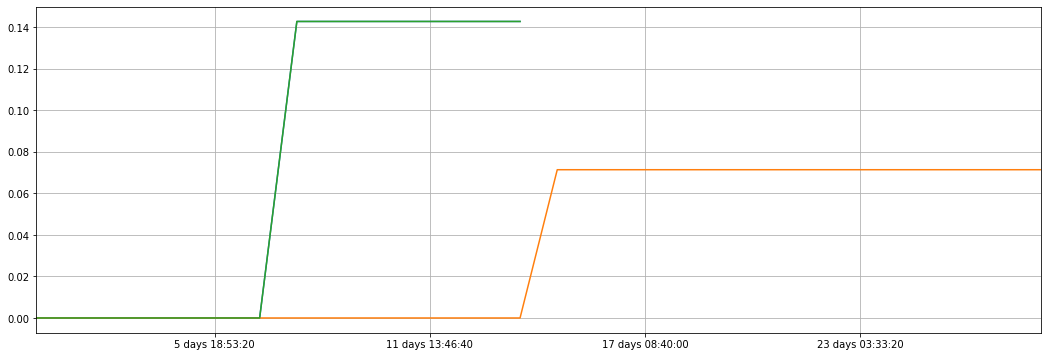

In [10]:
symptoms_to_recover_ir.plot()
moderate_severe_to_recover_ir.plot()
respirator_to_recover_ir.plot()

## basic time variables


exposed_new = np.zeros_like(t) #number of new cases during given day
moderate_severe_new = np.zeros_like(t)
respirated_new = np.zeros_like(t)
dead_new = np.zeros_like(t)
susceptible = np.zeros_like(t) #number of susceptipble people at the beginning of given day


In [12]:
R = 2
N = 200
population = 9 * 10 ** 6
t = np.arange(N)
t = pd.TimedeltaIndex(data=t, unit='day')


## some data

### tsvikas

In [62]:
confirmed_tsvik = pd.read_csv(Path('./../../COVID-19-Israel-data-tsvikas.git/daily_reports/total_cases.csv'), index_col=0, header=0, parse_dates=True, skiprows=[1,])

confirmed_tsvik.index = confirmed_tsvik.index.tz_localize(None).normalize()
confirmed_tsvik['date'] = confirmed_tsvik.index
#confirmed_tsvik
A = confirmed_tsvik.drop_duplicates(keep='last', subset='date')
A = A.iloc[2:]

In [63]:
A

total_cases    mild  serious  critical  recovering  dead  \
date                                                                   
2020-03-13          143   132.0      8.0       3.0         NaN   NaN   
2020-03-14          178   165.0     11.0       2.0         NaN   NaN   
2020-03-15          213   195.0     12.0       2.0         4.0   NaN   
2020-03-16          298   281.0      9.0       4.0         4.0   NaN   
2020-03-17          337   311.0     10.0       5.0        11.0   NaN   
2020-03-18          433   404.0     12.0       6.0        11.0   NaN   
2020-03-19          677   644.0     13.0       6.0        14.0   NaN   
2020-03-20          705   662.0     18.0      10.0        15.0   NaN   
2020-03-21          883   812.0     19.0      15.0        36.0   1.0   
2020-03-22         1071   985.0     30.0      18.0        37.0   1.0   
2020-03-23         1442  1331.0     40.0      29.0        41.0   1.0   
2020-03-24         1930  1795.0     45.0      34.0        53.0   3.0   
2020-03-25         2369  2197.0     64.0      39.0        64.0   5.0   
2020-03-26         2693  2502.0     67.0      46.0        70.0   8.0   
2020-03-27         3035  2838.0     60.0      49.0        79.0  10.0   
2020-03-28         3619  3383.0     81.0      54.0        89.0  12.0   
2020-03-29         4247  3944.0     82.0      74.0       132.0  15.0   
2020-03-30         4695  4349.0     90.0      79.0       161.0  16.0   
2020-03-31         5358  4916.0    105.0      94.0       224.0  20.0   
2020-04-01         6092  5602.0    129.0      95.0       241.0  25.0   
2020-04-02         6857  6252.0    126.0     108.0       338.0  34.0   
2020-04-03         7428  6718.0    155.0     113.0       403.0  39.0   
2020-04-04         7851  7059.0    165.0     126.0       458.0  43.0   
2020-04-05         8430  7515.0    182.0     139.0       546.0  49.0   
2020-04-06         8904  7841.0    197.0     140.0       670.0  57.0   
2020-04-07         9006  7930.0    181.0     153.0       683.0  59.0   

                 date  
date                   
2020-03-13 2020-03-13  
2020-03-14 2020-03-14  
2020-03-15 2020-03-15  
2020-03-16 2020-03-16  
2020-03-17 2020-03-17  
2020-03-18 2020-03-18  
2020-03-19 2020-03-19  
2020-03-20 2020-03-20  
2020-03-21 2020-03-21  
2020-03-22 2020-03-22  
2020-03-23 2020-03-23  
2020-03-24 2020-03-24  
2020-03-25 2020-03-25  
2020-03-26 2020-03-26  
2020-03-27 2020-03-27  
2020-03-28 2020-03-28  
2020-03-29 2020-03-29  
2020-03-30 2020-03-30  
2020-03-31 2020-03-31  
2020-04-01 2020-04-01  
2020-04-02 2020-04-02  
2020-04-03 2020-04-03  
2020-04-04 2020-04-04  
2020-04-05 2020-04-05  
2020-04-06 2020-04-06  
2020-04-07 2020-04-07

In [64]:
A.columns

Index(['total_cases', 'mild', 'serious', 'critical', 'recovering', 'dead',
       'date'],
      dtype='object')

A['symptomatic_new'] = A.mild.diff()
#A['symptomatic_overflow'] = A.symptomatic_new - A.mild.diff() 
#A
A['moderate_severe_tot'] = A.serious + A.

ax = A.total_cases.plot(linestyle='', marker='*')
confirmed.cases_tot.plot(ax=ax, linestyle='', marker='^')

### dard

In [13]:
empiric_approx_factor_hospitalized_to_moderate_severe = 3
empiric_approx_factor_respirated_to_severe = 0.66

In [14]:
confirmed = pd.read_csv(Path('./../../israel-covid19-data.git/IsraelCOVID19.csv'), index_col=0, header=0, names=['cases_tot', 'cases_new', 'moderate_tot', 'severe_tot', 'dead_tot'], parse_dates=True, dayfirst=True)
confirmed['respirated_new'] = empiric_approx_factor_respirated_to_severe * confirmed.severe_tot.diff()
confirmed['hospitalized_new'] = empiric_approx_factor_hospitalized_to_moderate_severe * (confirmed.moderate_tot + confirmed.severe_tot).diff()
confirmed['dead_new'] = confirmed.dead_tot.diff()
#confirmed['moderate_severe_tot'] = confirmed.moderate_tot + confirmed.severe_tot
#confirmed['moderate_severe_new'] = confirmed.moderate_severe_tot.diff()
confirmed[['cases_new', 'hospitalized_new', 'respirated_new', 'dead_new']]
#A = pd.concat([confirmed, confirmed_tsvik], axis=1, join='outer')
#A[['cases_tot', 'total_cases']]

cases_new  hospitalized_new  respirated_new  dead_new
2020-02-21          2               NaN             NaN       NaN
2020-02-22          0               NaN             NaN       NaN
2020-02-23          0               NaN             NaN       NaN
2020-02-24          0               NaN             NaN       NaN
2020-02-25          0               NaN             NaN       NaN
2020-02-26          1               NaN             NaN       NaN
2020-02-27          2               NaN             NaN       NaN
2020-02-28          2               NaN             NaN       NaN
2020-02-29          3               NaN             NaN       NaN
2020-03-01          2               NaN             NaN       NaN
2020-03-02          0               NaN             NaN       NaN
2020-03-03          3               NaN             NaN       NaN
2020-03-04          1               NaN             NaN       NaN
2020-03-05          4               NaN             NaN       NaN
2020-03-06          2               NaN             NaN       NaN
2020-03-07         15               NaN             NaN       NaN
2020-03-08          2               NaN             NaN       NaN
2020-03-09         20               6.0            0.66       0.0
2020-03-10         18               9.0            0.00       0.0
2020-03-11         22               3.0            0.00       0.0
2020-03-12         31               3.0            0.66       0.0
2020-03-13         34              12.0            0.66       0.0
2020-03-14         36               6.0           -0.66       0.0
2020-03-15         53               3.0            0.00       0.0
2020-03-16         65              -3.0            1.32       0.0
2020-03-17        103               6.0            0.66       0.0
2020-03-18        103               9.0            0.66       0.0
2020-03-19        153               3.0            0.00       0.0
2020-03-20        161              27.0            2.64       0.0
2020-03-21        105              18.0            3.30       1.0
2020-03-22        264              60.0            5.94       0.0
2020-03-23        345              39.0            3.30       0.0
2020-03-24        448              45.0            5.28       2.0
2020-03-25        463              63.0            1.32       2.0
2020-03-26        548              24.0            4.62       3.0
2020-03-27        393               3.0            1.98       4.0
2020-03-28        420             114.0           13.20       0.0
2020-03-29        492              18.0            3.30       3.0
2020-03-30        466              39.0            3.30       1.0
2020-03-31        741              90.0            9.90       4.0
2020-04-01        645              75.0            0.66       6.0
2020-04-02        733              30.0            8.58       8.0
2020-04-03        632              69.0            3.30       5.0
2020-04-04        458             102.0            8.58       4.0
2020-04-05        629              90.0            8.58       7.0
2020-04-06         31              33.0            1.32       1.0

## ------

T = len(infection_impulse_response)

In [220]:
#dates_initial_data = slice(pd.Timestamp('2020/03/09'), pd.Timestamp('2020/03/09') + infection_impulse_response.index[-1 - 1])
dates_initial_data = slice(pd.Timestamp('2020/03/01'), pd.Timestamp('2020/03/10'))
exposed_new_initial = confirmed.loc[dates_initial_data ].cases_new.values

confirmed2 = confirmed.loc[dates_initial_data.start:]
confirmed2 = confirmed2.set_index(t[:len(confirmed2)])

exposed_new[:T] = exposed_new_initial
susceptible[0] = population

# time propagation

In [16]:
def convolution_with_indices(cause, ir, mode='full'):
    if mode == 'valid':
        pad = np.array([np.nan, ] * len(ir))
        response = np.concatenate([pad, np.convolve(cause, ir.values, mode='valid')[:-1]])
    elif mode == 'full':
        response = np.concatenate([np.array([0]), np.convolve(cause, ir.values, mode='full')[:len(cause) - 1]])
    
    return response

def example_convolution_with_indices_valid():
    A = np.arange(5)
    A_ir = pd.Series([2, 1])
    expected = np.array([np.nan, np.nan, 2, 5, 8])
    print(A)
    print(convolution_with_indices(A, A_ir, 'valid'))
    print(expected)


def example_convolution_with_indices_full():
    A = np.arange(5)
    A_ir = pd.Series([2, 1])
    expected = np.array([0, 0, 2, 5, 8])
    print(A)
    print(convolution_with_indices(A, A_ir, 'full'))
    print(expected)

example_convolution_with_indices_valid()
example_convolution_with_indices_full()

[0 1 2 3 4]
[nan nan  2.  5.  8.]
[nan nan  2.  5.  8.]
[0 1 2 3 4]
[0 0 2 5 8]
[0 0 2 5 8]


for i in range(1, T):
    susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]

for i in range(T, N):
    susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
    exposed_new[i] = R * susceptible[i] / population * exposed_new[i - T : i].dot(infection_impulse_response[::-1])

exposed_tot = exposed_new.cumsum()
prediction = pd.DataFrame(index=t, data=exposed_new.T, columns=['exposed_new'])

prediction['symptomatic_new'] = symptomatic_new = conditinal_probability_exposed_to_symptoms * convolution_with_indices(exposed_new, exposed_to_symptoms_ir)
prediction['moderate_severe_new'] =  conditional_probability_symptoms_to_moderate_severe * convolution_with_indices(symptomatic_new, symptoms_to_moderate_severe_ir)
prediction['respirated_new'] = conditional_probability_symptoms_to_respirator * convolution_with_indices(symptomatic_new, symptoms_to_respirator_ir)
prediction['dead_new'] = conditional_probability_symptoms_to_death * convolution_with_indices(symptomatic_new, symptoms_to_death_ir)
prediction['hospitalized_new'] = empiric_approx_factor_hospitalized_to_moderate_severe * prediction['moderate_severe_new']
# exposed asymptomatic delay > immune
# symptomatic recover delay > immune
# moderate_severe recover delay > immune
# respirator recover delay > immune
prediction

In [ ]:
np.convolve(exposed_to_symptoms_ir, symptoms_to_recover_ir).sum()

### time propagation as a function, which will be used for fitting

In [17]:
def predict_epidemic_dynamics_full_prediction(exposed_new_initial,
                              R,
                              conditinal_probability_exposed_to_symptoms,
                              conditional_probability_symptoms_to_moderate_severe,
                              conditional_probability_symptoms_to_respirator,
                              conditional_probability_symptoms_to_death,
                              population,
                              N):
    #print(N)
    
    empiric_approx_factor_hospitalized_to_moderate_severe = 1
    
    
    t = np.arange(N)
    exposed_new = np.zeros_like(t) #number of new cases during given day
    moderate_severe_new = np.zeros_like(t)
    respirated_new = np.zeros_like(t)
    dead_new = np.zeros_like(t)
    susceptible = np.zeros_like(t) #number of susceptipble people at the beginning of given day
    population = 9 * 10 ** 6
    t = pd.TimedeltaIndex(data=t, unit='day', name='date')
    
    T = len(infection_impulse_response)
    #exposed_new[:T] = exposed_new_initial
    exposed_new[:len(exposed_new_initial)] = exposed_new_initial
    susceptible[0] = population
    
    
    for i in range(1, T):
        susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
    
    
    for i in range(T, N):
        susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
        exposed_new[i] = R * susceptible[i] / population * exposed_new[i - T : i].dot(infection_impulse_response[::-1])

    multi_index = pd.MultiIndex.from_tuples((('exposed', 'new'),), names=['patient', 'stage'])
    prediction = pd.DataFrame(index=t, data=exposed_new.T, columns=multi_index)
    
    exposed_tot = exposed_new.cumsum()
    prediction['symptomatic', 'new'] = symptomatic_new = conditinal_probability_exposed_to_symptoms * convolution_with_indices(exposed_new, exposed_to_symptoms_ir)
    prediction['moderate_severe', 'new'] =  conditional_probability_symptoms_to_moderate_severe * convolution_with_indices(symptomatic_new, symptoms_to_moderate_severe_ir)
    prediction['respirated', 'new'] = conditional_probability_symptoms_to_respirator * convolution_with_indices(symptomatic_new, symptoms_to_respirator_ir)
    prediction['dead', 'new'] = conditional_probability_symptoms_to_death * convolution_with_indices(symptomatic_new, symptoms_to_death_ir)
    prediction['hospitalized', 'new'] = empiric_approx_factor_hospitalized_to_moderate_severe * prediction['moderate_severe', 'new']

    prediction['recovered', 'new'] = (1 - conditional_probability_symptoms_to_moderate_severe) * convolution_with_indices(symptomatic_new, symptoms_to_recover_ir)
    prediction['recovered', 'new'] += (conditional_probability_symptoms_to_moderate_severe - conditional_probability_symptoms_to_respirator) / conditional_probability_symptoms_to_moderate_severe * \
        convolution_with_indices(prediction['moderate_severe', 'new'], moderate_severe_to_recover_ir)
    prediction['recovered', 'new'] += (conditional_probability_symptoms_to_respirator - conditional_probability_symptoms_to_death) / conditional_probability_symptoms_to_respirator * \
        convolution_with_indices(prediction['respirated', 'new'], respirator_to_recover_ir)
    
    
    
    return prediction

def predict_epidemic_dynamics(exposed_new_initial,
                              R,
                              conditinal_probability_exposed_to_symptoms,
                              conditional_probability_symptoms_to_moderate_severe,
                              conditional_probability_symptoms_to_respirator,
                              conditional_probability_symptoms_to_death,
                              population,
                              N):
    prediction = predict_epidemic_dynamics_full_prediction(exposed_new_initial,
                              R,
                              conditinal_probability_exposed_to_symptoms,
                              conditional_probability_symptoms_to_moderate_severe,
                              conditional_probability_symptoms_to_respirator,
                              conditional_probability_symptoms_to_death,
                              population,
                              N)
    
    #attribues_for_metric = ['exposed_new', 'hospitalized_new', 'respirated_new', 'dead_new']
    #attribues_for_metric = [['hospitalized', 'new'], ['respirated', 'new'], ['dead', 'new']]
    #prediction=prediction[attribues_for_metric]
    prediction = prediction.xs('new', level='stage', axis=1)[['hospitalized', 'respirated', 'dead']]
    
    return prediction.values

In [24]:
#transition_probability = pd.Series(
#index_1=pd.MultiIndex.fr(codes=(('exposed', 'symptomatic')), names=['from', 'to'])

transitions_daily = pd.DataFrame(index=t, columns=pd.MultiIndex.from_tuples((('exposed', 'symptomatic'),), names=['source', 'destination']))
transitions_daily

source          exposed
destination symptomatic
0 days              NaN
1 days              NaN
2 days              NaN
3 days              NaN
4 days              NaN
...                 ...
195 days            NaN
196 days            NaN
197 days            NaN
198 days            NaN
199 days            NaN

[200 rows x 1 columns]

In [164]:
for s in Status:
    print(s.name)

susceptible
exposed
symptomatic
moderate_severe
respirated
dead
recover


In [303]:
import warnings

def susceptible_exposed_time_propagation(N_steps, susceptible_0, exposed_new_initial, contact_population_size, contact_population_infector_new, infection_impulse_response, R, interactions_ratio, IS_FEEDBACK=False):
    """
    For the group you consider. Please understand:
    what is the size of the susceptible population
    
    What is the contacts pool of this group?
    what is the pool size?
    How many infected are in this group in any given day?
    What is the number of interactions ratio compared to normal interactions by normal person in normal day
    
    Normal people contact normal people (most of the population), normal interactions
    people that lower their interaction (such as 60 years old people, or caretakers): interact normal people, with fraction of interactions
    elders that live on their own: contact normal people, very low fraction of interactions
    elders that live with a caretaker: contact the pool of caretakers, with moderate fraction of interactions: few times a day cooking ETC
    """
    #warnings.warn('take care: changes array directly')
    T = len(infection_impulse_response)
    susceptible = np.zeros(N_steps)
    exposed_new = np.zeros(N_steps)
    
    if exposed_new_initial is None:
        exposed_new_initial = np.zeros(T)
    exposed_new[:len(exposed_new_initial)] = exposed_new_initial
    #print(exposed_new)
    susceptible[0] = susceptible_0

    if contact_population_infector_new == 'SUSCEPTIBLE_INFECTORS_SAME_POPULATION':
        contact_population_infector_new = exposed_new
        assert contact_population_infector_new is exposed_new
        #print(contact_population_infector_new)
    
    for i in range(1, len(exposed_new_initial)):
        susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
    
    for i in range(len(exposed_new_initial), N_steps):
        susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
        exposed_new[i] = susceptible[i] * min(1, (contact_population_infector_new[i - T : i] / contact_population_size).dot(R * interactions_ratio * infection_impulse_response[::-1]))
        #print(exposed_new[i])
        #R * interactions_ratio / population * infector_new[i - T : i].dot(infection_impulse_response[::-1]))
    
    #assert exposed_new is contact_population_infector_new
    return susceptible, exposed_new

_, exposed_new_try =  susceptible_exposed_time_propagation(N_steps=100, susceptible_0=population, exposed_new_initial=exposed_new_initial / transitions[SourceDestination(Status.exposed, Status.symptomatic)].p, contact_population_size=population, contact_population_infector_new="SUSCEPTIBLE_INFECTORS_SAME_POPULATION", infection_impulse_response=infection_impulse_response, R=2, interactions_ratio=1)


In [256]:
exposed_new_initial

array([ 2,  0,  3,  1,  4,  2, 15,  2, 20, 18])

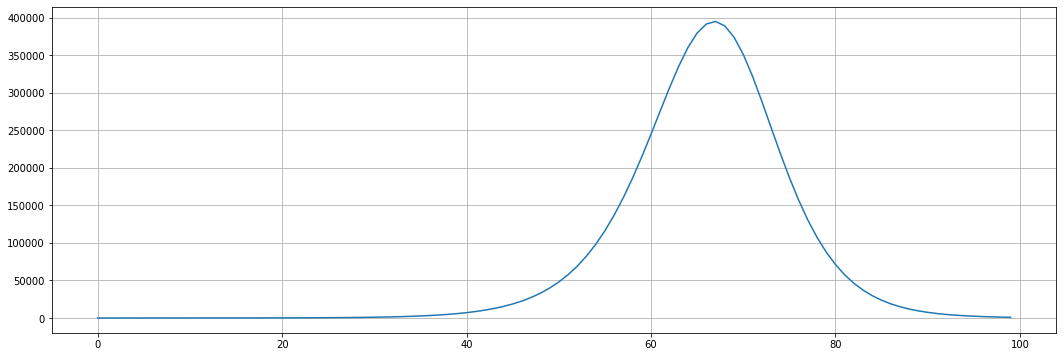

In [267]:
pd.Series(exposed_new_try).plot()

In [245]:
list(range(3, 10))

[3, 4, 5, 6, 7, 8, 9]

In [ ]:
{'population_type' : ('s_0', 'infector', 'interactions_ratio')}

In [316]:
def sigmoid(t, K, A, Q, B):
    return K + A / (1 + Q * np.exp(B * t-10))


population = 9 * 10 ** 6


def predict_epidemic_dynamics_full_prediction_2(exposed_new_initial, R, transitions, population, N, sigmoid_params=None):
    #print(N)
    
    #empiric_approx_factor_hospitalized_to_moderate_severe = 1
    
    t = np.arange(N)
    t = pd.TimedeltaIndex(data=t, unit='day', name='date')

    if False:
        exposed_new = np.zeros(N) #number of new cases during given day
        #moderate_severe_new = np.zeros_like(t)
        #respirated_new = np.zeros_like(t)
        #dead_new = np.zeros_like(t)
        susceptible = np.zeros(N) #number of susceptipble people at the beginning of given day

        T = len(infection_impulse_response)
        #exposed_new[:T] = exposed_new_initial
        exposed_new[:len(exposed_new_initial)] = exposed_new_initial
        susceptible[0] = population


        if not sigmoid_params is None and not R is None:
            raise ValueError('given both R and sigmoid params')
        if not sigmoid_params is None and R is None:
            R_t = sigmoid(t, **sigmoid_params)
        else:
            R_t = np.ones_like(t) * R

        # time propagation susceptible and exposed (/ infectious, it's the same for new)
        for i in range(1, len(exposed_new_initial)):
            susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]

        for i in range(len(exposed_new_initial), N):
            susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
            exposed_new[i] = R_t[i] * susceptible[i] / population * exposed_new[i - T : i].dot(infection_impulse_response[::-1])
    
    susceptible, exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=population, exposed_new_initial=exposed_new_initial, contact_population_size=population, contact_population_infector_new="SUSCEPTIBLE_INFECTORS_SAME_POPULATION", infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=1)
    # now population that keeps low interactions. such as 60 years old, and caretakers
    low_population = 5e5
    low_interaction_ratio = 0.2
    low_susceptible, low_exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=low_population, exposed_new_initial=None, contact_population_size=population, contact_population_infector_new=exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=low_interaction_ratio)
    
    # now population that gets deliveries twice a week
    supplies_population = 2e5
    supplies_interaction_ratio = 0.05
    supplies_susceptible, supplies_exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=supplies_population, exposed_new_initial=None, contact_population_size=population, contact_population_infector_new=exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=supplies_interaction_ratio)

    # now poulation that lives with a caretaker
    supported_population = 2e5
    supported_interaction_ratio = 0.5
    supported_susceptible, supported_exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=supported_population, exposed_new_initial=None, contact_population_size=low_population, contact_population_infector_new=low_exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=supported_interaction_ratio)
    
    #supported_elders_exposed_new = np.zeros_like(t)
    #for i in range(T, N):
    #    supported_elders_exposed_new[i] = R * exposed_new[i - T : i].dot(infection_impulse_response[::-1])
    
    multi_index = pd.MultiIndex.from_tuples((('exposed', 'new'),), names=['status', 'attr'])
    dynamics = prediction = pd.DataFrame(index=t, data=exposed_new.T, columns=multi_index)
    dynamics['low_exposed', 'new'] = low_exposed_new
    dynamics['supllies_exposed', 'new'] = supplies_exposed_new
    dynamics['supported_exposed', 'new'] = supported_exposed_new

    # derive the transitions between states
    transitions_daily = pd.DataFrame(index=t, data=exposed_new.T, columns=pd.MultiIndex.from_tuples((('susceptible', 'exposed'),), names=['source', 'destination']))
    
    for source_dest, params in transitions.items():
        assert source_dest.source < source_dest.destination
        source, dest = source_dest.source.name, source_dest.destination.name
        print(source, dest)
        transitions_daily[source, dest] = params.p * convolution_with_indices(dynamics[source, 'new'], params.impulse_response)
        if (dest, 'new') in dynamics.columns:
            dynamics[dest, 'new'] += transitions_daily[source, dest]
        else:
            dynamics[dest, 'new'] = transitions_daily[source, dest]
    
    # checksum
    if True:
        for s in Status:
            if (s.name, 'new') in dynamics.columns:
                assert np.allclose(dynamics[s.name, 'new'], transitions_daily.xs(s.name, level='destination', axis=1).sum(axis=1))
    # net change
    if True:
        for s in Status:
            if (s.name, 'new') in dynamics.columns and s.name in transitions_daily.columns.to_frame(index=False).source.values:
                dynamics[s.name, 'net_delta'] = dynamics[s.name, 'new'] - transitions_daily.xs(s.name, level='source', axis=1).sum(axis=1)

    
    
    if False:
        #exposed_tot = exposed_new.cumsum()
        transitions_daily['exposed', 'symptomatic'] = prediction['symptomatic', 'new'] = symptomatic_new = conditinal_probability_exposed_to_symptoms * convolution_with_indices(exposed_new, exposed_to_symptoms_ir)
        transitions_daily['symptomatic', 'moderate_severe'] = prediction['moderate_severe', 'new'] =  conditional_probability_symptoms_to_moderate_severe * convolution_with_indices(symptomatic_new, symptoms_to_moderate_severe_ir)
        transitions_daily['symptomatic', 'respirated'] = prediction['respirated', 'new'] = conditional_probability_symptoms_to_respirator * convolution_with_indices(symptomatic_new, symptoms_to_respirator_ir)
        transitions_daily['symptomatic', 'dead'] = prediction['dead', 'new'] = conditional_probability_symptoms_to_death * convolution_with_indices(symptomatic_new, symptoms_to_death_ir)
        prediction['hospitalized', 'new'] = empiric_approx_factor_hospitalized_to_moderate_severe * prediction['moderate_severe', 'new']

        transitions_daily['symptomatic', 'recovered'] = prediction['recovered', 'new'] = (1 - conditional_probability_symptoms_to_moderate_severe) * convolution_with_indices(symptomatic_new, symptoms_to_recover_ir)
        p_moderate_severe_recover = (conditional_probability_symptoms_to_moderate_severe - conditional_probability_symptoms_to_respirator) / conditional_probability_symptoms_to_moderate_severe
        transitions_daily['moderate_severe', 'recovered'] = p_moderate_severe_recover * convolution_with_indices(prediction['moderate_severe', 'new'], moderate_severe_to_recover_ir)
        p_respirated_recovered = (conditional_probability_symptoms_to_respirator - conditional_probability_symptoms_to_death) / conditional_probability_symptoms_to_respirator
        transitions_daily['respirated', 'recovered'] = p_respirated_recovered * convolution_with_indices(prediction['respirated', 'new'], respirator_to_recover_ir)
        #prediction['recovered', 'new'] += (conditional_probability_symptoms_to_moderate_severe - conditional_probability_symptoms_to_respirator) / conditional_probability_symptoms_to_moderate_severe * \
        #    convolution_with_indices(prediction['moderate_severe', 'new'], moderate_severe_to_recover_ir)
        #prediction['recovered', 'new'] += (conditional_probability_symptoms_to_respirator - conditional_probability_symptoms_to_death) / conditional_probability_symptoms_to_respirator * \
        #    convolution_with_indices(prediction['respirated', 'new'], respirator_to_recover_ir)
        #prediction['symptomatic', 'net_delta'] = 

    if False:
        prediction['symptomatic', 'net_delta'] = prediction['symptomatic', 'new'] - transitions_daily.xs('symptomatic', level='source', axis=1).sum(axis=1)
        prediction['recovered', 'net_delta'] = transitions_daily.xs('recovered', level='destination', axis=1).sum(axis=1)

    return dynamics, transitions_daily

In [317]:
prediction_2, transitions_daily_2 = predict_epidemic_dynamics_full_prediction_2(exposed_new_initial=exposed_new_initial / transitions[SourceDestination(Status.exposed, Status.symptomatic)].p,
                              R=2,
                              transitions=transitions,
                              population=population,
                              N=100)


/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


exposed symptomatic
symptomatic moderate_severe
symptomatic respirated
symptomatic dead
symptomatic recover
moderate_severe recover
respirated recover


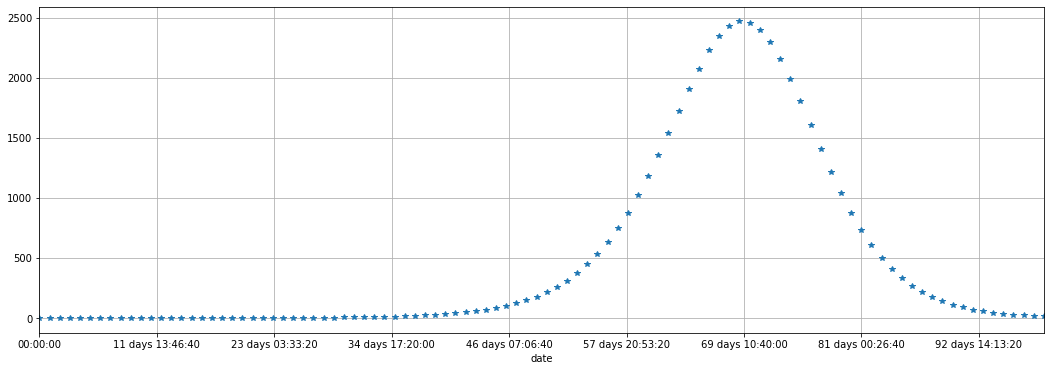

In [324]:
prediction_2.supported_exposed.new.plot(linestyle='', marker='*')

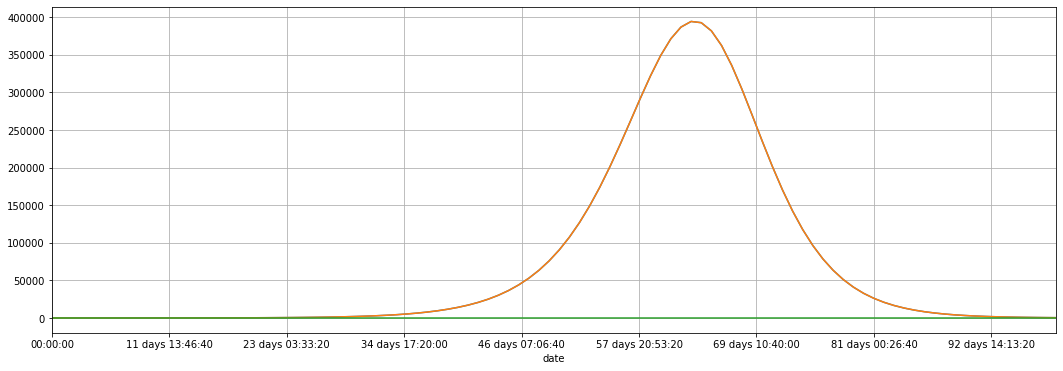

In [306]:
tmp = pd.Series(index=prediction_2.index, data = exposed_new_try)
ax = tmp.iloc[:].plot()
prediction_2.exposed.new.iloc[:].plot(ax=ax)
(tmp - prediction_2.exposed.new).plot(ax=ax)

In [287]:
prediction_2.exposed.new.values - exposed_new_try

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.06124999e-01, -4.17363390e-01,
       -9.29169832e-01, -6.12048331e-01, -1.38443209e+00, -1.92718010e+00,
       -1.83044481e+00, -2.44012294e+00, -3.78165967e+00, -3.67044520e+00,
       -5.34378675e+00, -5.97704833e+00, -7.97079346e+00, -9.15968843e+00,
       -1.20539317e+01, -1.38561463e+01, -1.77804171e+01, -2.10572202e+01,
       -2.62939221e+01, -3.17330947e+01, -3.85718674e+01, -4.73890227e+01,
       -5.76416083e+01, -7.02540087e+01, -8.53273974e+01, -1.03976155e+02,
       -1.25323770e+02, -1.52663783e+02, -1.84810779e+02, -2.23651725e+02,
       -2.70897310e+02, -3.27017481e+02, -3.94315333e+02, -4.75047772e+02,
       -5.70434186e+02, -6.83295714e+02, -8.15930938e+02, -9.70648224e+02,
       -1.14813652e+03, -1.35056803e+03, -1.57700973e+03, -1.82543124e+03,
       -2.09044383e+03, -

In [217]:
transitions_daily_2.columns.to_frame(index=False).source.values

array(['susceptible', 'exposed', 'symptomatic', 'symptomatic',
       'symptomatic', 'symptomatic', 'moderate_severe', 'respirated'],
      dtype=object)

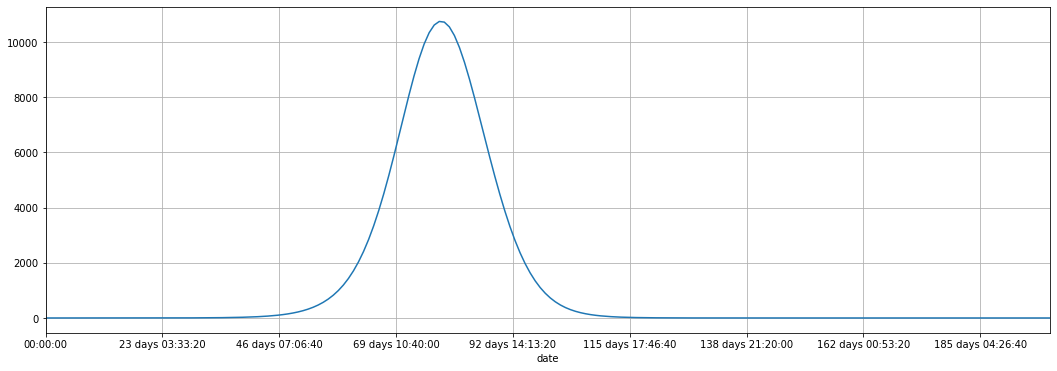

In [229]:
prediction_2.moderate_severe.new.plot()

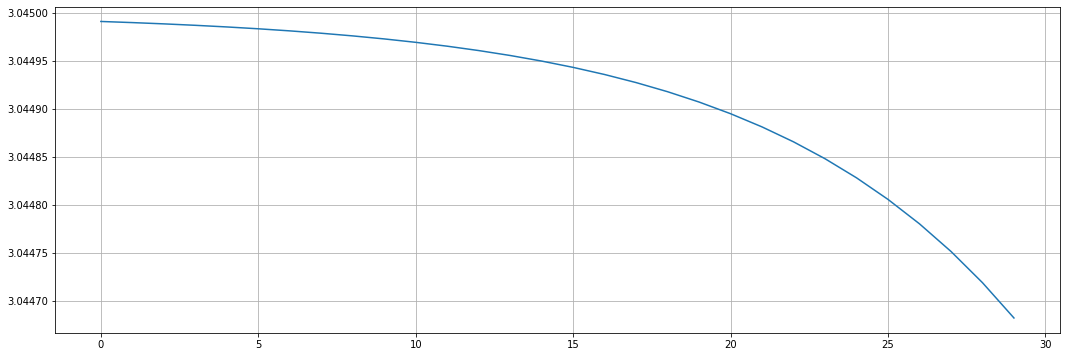

In [239]:
sigmoid_params = {'K' : 0, 'A' : 3.045, 'Q' : 0.065, 'B' : 0.123}
pd.Series(sigmoid(np.arange(30), **sigmoid_params)).plot()

In [240]:
prediction_2, transitions_daily_2 = predict_epidemic_dynamics_full_prediction_2(exposed_new_initial=exposed_new_initial / transitions[SourceDestination(Status.exposed, Status.symptomatic)].p,
                              R=None,
                              transitions=transitions,
                              population=population,
                              N=N,
                              sigmoid_params=sigmoid_params)


exposed symptomatic
symptomatic moderate_severe
symptomatic respirated
symptomatic dead
symptomatic recover
moderate_severe recover
respirated recover


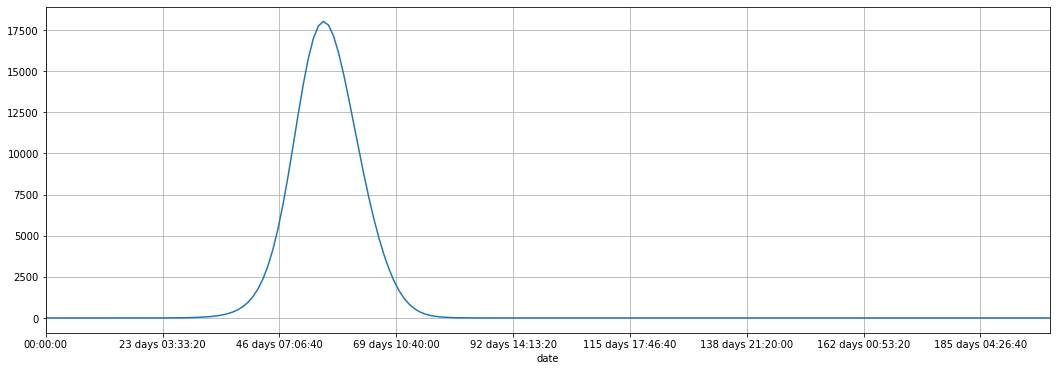

In [241]:
prediction_2.moderate_severe.new.plot()

In [147]:
('exposed', 'new') in prediction_2.columns

True

In [ ]:

_ = pd.DataFrame(data=[1, 2, 3], columns=pd.MultiIndex.from_tuples((('symptomatic', 'new'),), names=['patient', 'stage']))
_['symptomatic', 'active'] = [1, 2, 3]
_

In [18]:
out = predict_epidemic_dynamics(exposed_new_initial=exposed_new_initial,
                              R=R,
                              conditinal_probability_exposed_to_symptoms=conditinal_probability_exposed_to_symptoms,
                              conditional_probability_symptoms_to_moderate_severe=conditional_probability_symptoms_to_moderate_severe,
                              conditional_probability_symptoms_to_respirator=conditional_probability_symptoms_to_respirator,
                              conditional_probability_symptoms_to_death=conditional_probability_symptoms_to_death,
                              population=population,
                              N=N)

out

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.96214394e-05, 1.25744942e-05, 3.06461985e-06],
       [8.98769259e-04, 1.68362669e-04, 4.24331694e-05],
       [4.42297334e-03, 8.76949670e-04, 2.32122468e-04],
       [1.36547355e-02, 2.85463213e-03, 7.89423234e-04],
       [3.19537416e-02, 6.99868594e-03, 2.00899570e-03],
       [6.23238089e-02, 1.42206404e-02, 4.21466402e-03],
       [1.06888541e-01, 2.52937126e-02, 7.70813685e-03],
       [1.66923351e-01, 4.07979362e-02, 1.27391993e-02],
       [2.43536694e-01, 6.12219556e-02, 1.95222155e-02],
       [3.38293659e-01, 8.71091492e-02, 2.82772194e-02],
       [4.53407679e-01, 1.19136779e-01, 3.92597469e-02],
       [5.91714084e-01, 1.58139769e-01, 5.27748004e-02],
       [7.56939631e-01, 2.05174211e-01, 6.91973738e-02],
       [9.54047558e-01, 2.61615407e-01, 8.90059410e-02],
       [1.18946233e+00, 3.29236914e-01, 1.12812899e-01],
       [1.47133710e+00, 4.10294

### fitting

In [51]:
from lmfit import Model
epidemic_model = Model(predict_epidemic_dynamics)
print('parameter names: {}'.format(epidemic_model.param_names))
print('independent variables: {}'.format(epidemic_model.independent_vars))

params = epidemic_model.make_params()

parameter names: ['R', 'conditinal_probability_exposed_to_symptoms', 'conditional_probability_symptoms_to_moderate_severe', 'conditional_probability_symptoms_to_respirator', 'conditional_probability_symptoms_to_death', 'population', 'N']
independent variables: ['exposed_new_initial']


In [52]:
params['R'].set(value=2, vary=None, min=0, max=10, expr=None, brute_step=None)
params['conditinal_probability_exposed_to_symptoms'].set(value=conditinal_probability_exposed_to_symptoms, vary=False, min=0, max=1, expr=None, brute_step=None)
params['conditional_probability_symptoms_to_moderate_severe'].set(value=conditional_probability_symptoms_to_moderate_severe, vary=True, min=0, max=1, expr=None, brute_step=None)
params['conditional_probability_symptoms_to_respirator'].set(value=conditional_probability_symptoms_to_respirator, vary=True, min=0, max=1, expr=None, brute_step=None)
params['conditional_probability_symptoms_to_death'].set(value=conditional_probability_symptoms_to_death, vary=True, min=0, max=1, expr=None, brute_step=None)
params['population'].set(value=population, vary=False)
params['N'].set(value=len(confirmed2), vary=False)

In [ ]:
out = epidemic_model.eval(params, exposed_new_initial=exposed_new_initial)
out.shape

In [ ]:
#attributes_for_metric = ['cases_new', 'hospitalized_new', 'respirated_new', 'dead_new']
attributes_for_metric = ['hospitalized_new', 'respirated_new', 'dead_new']

y = confirmed2[attributes_for_metric].values.copy()
fit_result = epidemic_model.fit(y, params, exposed_new_initial=exposed_new_initial, method='dual_annealing')

In [ ]:
pprint(fit_result.fit_report())

### plot prediction and data

In [ ]:
prediction.plot(linestyle='', marker='.')

In [ ]:
confirmed2

In [ ]:
ax = prediction.exposed_new[:len(confirmed2)].plot()
confirmed2.cases_new.plot(ax=ax, linestyle='', marker='*')
#ax.set_xlim(['0 days', '100 days'])

In [ ]:
ax = prediction.hospitalized_new[:len(confirmed2)].plot()
confirmed2.hospitalized_new.plot(ax=ax, linestyle='', marker='*')

In [ ]:
ax = prediction.respirated_new[:len(confirmed2)].plot()
confirmed2.respirated_new.plot(ax=ax, linestyle='', marker='*')

In [ ]:
ax = prediction.dead_new[:len(confirmed2)].plot()
confirmed2.dead_new.plot(ax=ax, linestyle='', marker='*')

### preform fit

In [ ]:
sp.optimize.curve_fit??

### run prediction based  on new cases data on the week before 2020_03_22

In [61]:
conditinal_probability_exposed_to_symptoms

0.5

In [53]:
dates_initial_data = slice(pd.Timestamp('2020/03/09'), pd.Timestamp('2020/04/06'))
exposed_new_initial_2 = confirmed.loc[dates_initial_data ].cases_new.values


In [54]:
params['R'].set(value=1.2, vary=None, min=0, max=10, expr=None, brute_step=None)
params['conditinal_probability_exposed_to_symptoms'].set(value=conditinal_probability_exposed_to_symptoms, vary=False, min=0, max=1, expr=None, brute_step=None)
params['conditional_probability_symptoms_to_moderate_severe'].set(value=conditional_probability_symptoms_to_moderate_severe, vary=True, min=0, max=1, expr=None, brute_step=None)
params['conditional_probability_symptoms_to_respirator'].set(value=conditional_probability_symptoms_to_respirator, vary=True, min=0, max=1, expr=None, brute_step=None)
params['conditional_probability_symptoms_to_death'].set(value=conditional_probability_symptoms_to_death, vary=True, min=0, max=1, expr=None, brute_step=None)
params['population'].set(value=population, vary=False)
params['N'].set(value=300, vary=False)

#out = epidemic_model.eval(params, exposed_new_initial=exposed_new_initial_2)
out, transitions_daily = predict_epidemic_dynamics_full_prediction_2(exposed_new_initial=exposed_new_initial_2, **params.valuesdict())
out.index = out.index + dates_initial_data.start

In [56]:
out

patient    exposed symptomatic moderate_severe respirated      dead  \
stage          new         new             new        new       new   
date                                                                  
2020-03-09      20    0.000000        0.000000   0.000000  0.000000   
2020-03-10      18    0.060040        0.000000   0.000000  0.000000   
2020-03-11      22    0.612851        0.000070   0.000013  0.000003   
2020-03-12      31    1.907393        0.000899   0.000168  0.000042   
2020-03-13      34    3.751237        0.004423   0.000877  0.000232   
...            ...         ...             ...        ...       ...   
2020-12-29     263  174.199339       17.566500   6.627762  2.778845   
2020-12-30     250  165.579852       16.700214   6.301229  2.642019   
2020-12-31     238  157.362793       15.876263   5.990621  2.511856   
2021-01-01     226  149.528602       15.092603   5.695177  2.388041   
2021-01-02     215  142.076222       14.347241   5.414158  2.270266   

patient    hospitalized   recovered symptomatic   recovered  
stage               new         new   net_delta   net_delta  
date                                                         
2020-03-09     0.000000    0.000000    0.000000    0.000000  
2020-03-10     0.000000    0.000000    0.060040    0.000000  
2020-03-11     0.000070    0.000000    0.612766    0.000000  
2020-03-12     0.000899    0.000000    1.906284    0.000000  
2020-03-13     0.004423    0.000000    3.745705    0.000000  
...                 ...         ...         ...         ...  
2020-12-29    17.566500  285.412715 -138.186484  326.659717  
2020-12-30    16.700214  271.351790 -131.415401  310.601158  
2020-12-31    15.876263  257.980616 -124.996562  295.326767  
2021-01-01    15.092603  245.264513 -118.911732  280.797597  
2021-01-02    14.347241  233.168658 -113.124101  266.974729  

[300 rows x 9 columns]

In [ ]:
out[['symptomatic_new', 'moderate_severe_new', 'respirated_new', 'dead_new']].plot()

### gartner new predictions

In [57]:
df = pd.read_csv(path_data.joinpath('epidemic_models/gartner_predictions_2.csv'), index_col=[0, 1, 2, 3], dayfirst=True, thousands=',')

df = df.swapaxes(0, 1)
df.index.name = 'date'
df.index = pd.to_datetime(df.index, dayfirst=True)


df.columns.names = ['r', 'proportion_detected', 'patient', 'new_active']

tmp = df.columns.to_frame(index=False)
tmp.patient = tmp.patient.astype('category').cat.rename_categories({'Moderate-Severe' : 'moderate_severe', 'Respirator' : 'respirator', 'Symptomatic' : 'symptomatic'})
tmp.proportion_detected = np.round(tmp.proportion_detected.str.extract('(\d+)').astype(float) * 0.01, 3)
tmp.new_active = tmp.new_active.str.replace(' patients', '').str.lower().astype('category')#.cat.rename_categories({'new patients' : 'new', 'active patients' : 'active'})
df.columns = pd.MultiIndex.from_frame(tmp)

#df.columns
#df.dtypes
df

r                           1.2                                      \
proportion_detected         0.3         0.5         0.7         0.3   
patient             symptomatic symptomatic symptomatic symptomatic   
new_active                  new         new         new      active   
date                                                                  
2020-03-22                 2900        2800        2800        2900   
2020-03-29                 4300        4300        4200        4300   
2020-04-05                 5900        5900        5900        5900   
2020-04-12                 7700        7800        7800        7700   
2020-04-19                 9500        9700        9900        9500   
2020-04-26                12000       12000       12000       12000   
2020-05-03                14000       15000       16000       14000   
2020-05-10                17000       18000       19000       17000   
2020-05-17                20000       22000       24000       20000   
2020-05-24                23000       27000       30000       23000   
2020-05-31                27000       32000       37000       27000   
2020-06-07                30000       38000       44000       30000   
2020-06-14                33000       44000       53000       33000   
2020-06-21                36000       50000       62000       36000   
2020-06-28                38000       56000       72000       38000   
2020-07-05                39000       61000       81000       39000   
2020-07-12                39000       65000       90000       39000   
2020-07-19                38000       68000       97000       39000   
2020-07-26                36000       69000      100000       38000   
2020-08-02                34000       67000      100000       36000   
2020-08-09                31000       64000      100000       33000   
2020-08-16                27000       60000       97000       30000   
2020-08-23                24000       54000       90000       27000   
2020-08-30                20000       48000       81000       23000   
2020-09-06                17000       41000       72000       20000   
2020-09-13                14000       35000       62000       17000   
2020-09-20                12000       30000       52000       14000   
2020-09-27                 9500       25000       44000       11000   
2020-10-04                 7700       20000       36000        9200   
2020-10-11                 6200       16000       29000        7500   
2020-10-18                 5000       13000       23000        6000   
2020-10-25                 4000       11000       19000        4800   
2020-11-01                 3200        8400       15000        3900   
2020-11-08                 2500        6700       12000        3100   
2020-11-15                 2000        5300        9200        2500   
2020-11-22                 1600        4200        7200        2000   
2020-11-29                 1300        3300        5600        1600   
2020-12-06                 1000        2600        4400        1200   
2020-12-13                  800        2100        3400         970   
2020-12-20                  630        1600        2700         770   
2020-12-27                  500        1300        2100         610   

r                                                                            \
proportion_detected         0.5         0.7             0.3             0.5   
patient             symptomatic symptomatic moderate_severe moderate_severe   
new_active               active      active             new             new   
date                                                                          
2020-03-22                 3600        4200             130             130   
2020-03-29                 5700        7100             230             220   
2020-04-05                 7900       10000             330             320   
2020-04-12                10000       14000             440             440   
2020-04-19            

### it seems that the diff between active and new is sometimes 0, weird, the difference is bigger when proportion_detected is bigger

In [113]:
(df.xs('active', level='new_active', axis=1) - df.xs('new', level='new_active', axis=1)).xs(0.5, level='proportion_detected', axis=1)

r          1.20                                        1.35                  \
patient    Dead moderate_severe respirator symptomatic Dead moderate_severe   
date                                                                          
2020-03-22  NaN              30          9         800  NaN              30   
2020-03-29  NaN              70         20        1400  NaN              70   
2020-04-05  NaN             110         40        2000  NaN             110   
2020-04-12  NaN             150         50        2200  NaN             160   
2020-04-19  NaN             200         60        3300  NaN             220   
2020-04-26  NaN             260         80        5000  NaN             300   
2020-05-03  NaN             330        110        5000  NaN             500   
2020-05-10  NaN             400        130        7000  NaN             700   
2020-05-17  NaN             500        160        9000  NaN            1100   
2020-05-24  NaN             600        200       10000  NaN            1600   
2020-05-31  NaN             700        240       12000  NaN            2200   
2020-06-07  NaN             800        330       14000  NaN            3300   
2020-06-14  NaN            1000        300       17000  NaN            4000   
2020-06-21  NaN            1200        400       20000  NaN            4000   
2020-06-28  NaN            1300        500       23000  NaN            6000   
2020-07-05  NaN            1600        500       25000  NaN            6000   
2020-07-12  NaN            1600        600       27000  NaN            7000   
2020-07-19  NaN            1800        600       28000  NaN            7400   
2020-07-26  NaN            1900        600       29000  NaN            6600   
2020-08-02  NaN            1900        600       31000  NaN            5600   
2020-08-09  NaN            2000        700       32000  NaN            4200   
2020-08-16  NaN            2100        700       32000  NaN            3000   
2020-08-23  NaN            2100        800       32000  NaN            2000   
2020-08-30  NaN            2000        700       30000  NaN            1400   
2020-09-06  NaN            1900        700       28000  NaN             900   
2020-09-13  NaN            1700        670       25000  NaN             550   
2020-09-20  NaN            1500        510       21000  NaN             380   
2020-09-27  NaN            1400        440       18000  NaN             250   
2020-10-04  NaN            1100        410       16000  NaN             150   
2020-10-11  NaN            1000        350       13000  NaN              97   
2020-10-18  NaN             800        290       11000  NaN              63   
2020-10-25  NaN             700        230        8000  NaN              39   
2020-11-01  NaN             560        190        6600  NaN              25   
2020-11-08  NaN             430        150        5300  NaN              16   
2020-11-15  NaN             340        130        4400  NaN              11   
2020-11-22  NaN             270        100        3500  NaN               6   
2020-11-29  NaN             210         76        2800  NaN               4   
2020-12-06  NaN             170         66        2200  NaN               2   
2020-12-13  NaN             130         51        1700  NaN               2   
2020-12-20  NaN             110         39        1400  NaN               1   
2020-12-27  NaN              82         31        1100  NaN               1   

r                                 1.50                                         \
patient    respirator symptomatic Dead moderate_severe respirator symptomatic   
date                                                                            
2020-03-22          9         800  NaN              30          9         800   
2020-03-29         20        1400  NaN              70         20        1400   
2020-04-05         40        2000  NaN             110         40        2000   
2020-04-12         50        2500  Na

In [105]:
df.columns.to_frame(index=False).proportion_detected.unique()

array([0.3, 0.5, 0.7])

proportion_detected            0.3       0.5            0.7
date                                                       
2020-03-22             9666.666667    5600.0    4000.000000
2020-03-29            14333.333333    8600.0    6000.000000
2020-04-05            19666.666667   11800.0    8428.571429
2020-04-12            25666.666667   15600.0   11142.857143
2020-04-19            31666.666667   19400.0   14142.857143
2020-04-26            40000.000000   24000.0   17142.857143
2020-05-03            46666.666667   30000.0   22857.142857
2020-05-10            56666.666667   36000.0   27142.857143
2020-05-17            66666.666667   44000.0   34285.714286
2020-05-24            76666.666667   54000.0   42857.142857
2020-05-31            90000.000000   64000.0   52857.142857
2020-06-07           100000.000000   76000.0   62857.142857
2020-06-14           110000.000000   88000.0   75714.285714
2020-06-21           120000.000000  100000.0   88571.428571
2020-06-28           126666.666667  1120

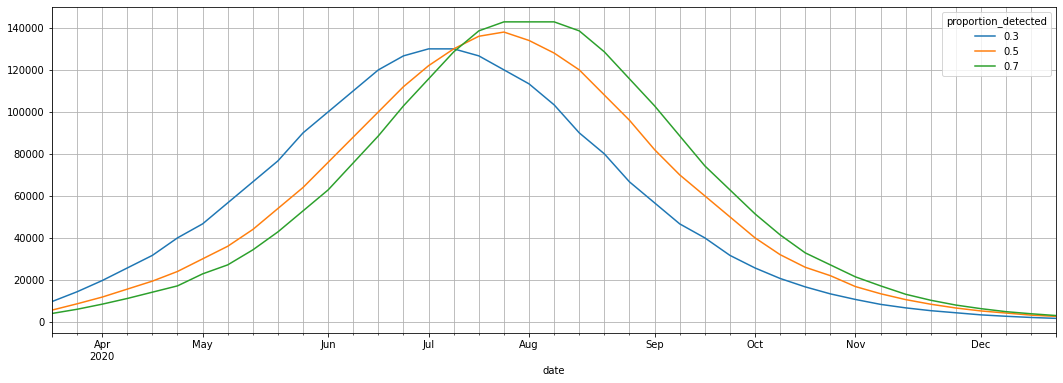

In [107]:
_ = df.xs((1.2, 'new', 'symptomatic'), level=('r', 'new_active', 'patient'), axis=1) / df.columns.to_frame(index=False).proportion_detected.unique()
print(_)
_.plot()

## issues:
* resolution: days Vs weeks
* fence: their data is for last week or next week?
* they also compute the effect of people recovering
* for the data, for gatner model: is it cumulative? is it "symptoms and above" or "symptoms but not above"

* clean code
* analyse their outputs against one another
* try to change my assumptions
* soft social distancing model

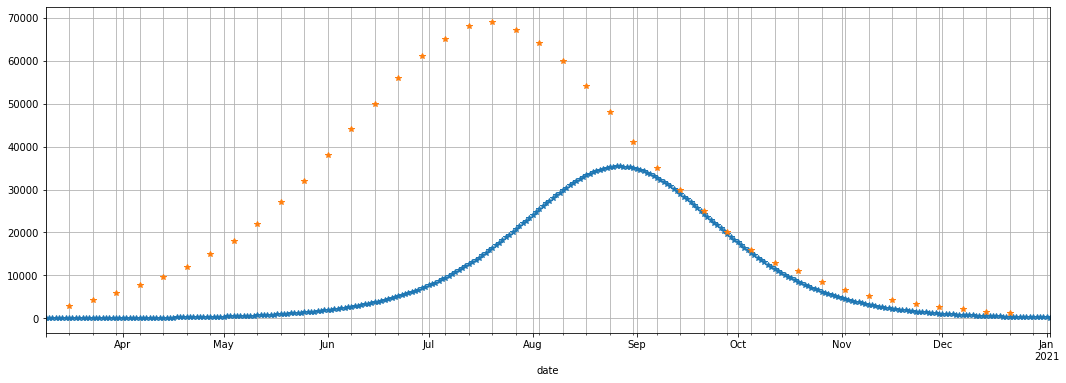

In [108]:
df_temp = df.xs([1.2, 0.5, 'new'], level=['r', 'proportion_detected', 'new_active'], axis=1)

ax = out['exposed', 'new'].plot(linestyle='', marker='*')
(df_temp.symptomatic / 1).plot(ax=ax, linestyle='', marker='*')
cmp = pd.concat([df_temp.symptomatic, out['symptomatic', 'new'], confirmed.cases_new], axis=1)

### issue of initial conditions: in my simulation I insert to exposed (infective) data of symptomatic cases
* delay issue: they will take time to ripen
* amount issue: factor
* do they delay between symptomatic and exposed?

In [78]:
cmp[:50]

symptomatic  (symptomatic, new)  cases_new
2020-02-21          NaN                 NaN        2.0
2020-02-22          NaN                 NaN        0.0
2020-02-23          NaN                 NaN        0.0
2020-02-24          NaN                 NaN        0.0
2020-02-25          NaN                 NaN        0.0
2020-02-26          NaN                 NaN        1.0
2020-02-27          NaN                 NaN        2.0
2020-02-28          NaN                 NaN        2.0
2020-02-29          NaN                 NaN        3.0
2020-03-01          NaN                 NaN        2.0
2020-03-02          NaN                 NaN        0.0
2020-03-03          NaN                 NaN        3.0
2020-03-04          NaN                 NaN        1.0
2020-03-05          NaN                 NaN        4.0
2020-03-06          NaN                 NaN        2.0
2020-03-07          NaN                 NaN       15.0
2020-03-08          NaN                 NaN        2.0
2020-03-09          NaN            0.000000       20.0
2020-03-10          NaN            0.060040       18.0
2020-03-11          NaN            0.612851       22.0
2020-03-12          NaN            1.907393       31.0
2020-03-13          NaN            3.751237       34.0
2020-03-14          NaN            5.958783       36.0
2020-03-15          NaN            8.389559       53.0
2020-03-16          NaN           10.881114       65.0
2020-03-17          NaN           13.594233      103.0
2020-03-18          NaN           16.786732      103.0
2020-03-19          NaN           19.898430      153.0
2020-03-20          NaN           22.302168      161.0
2020-03-21          NaN           23.973383      105.0
2020-03-22       2800.0           25.377349      264.0
2020-03-23          NaN           26.694483      345.0
2020-03-24          NaN           27.992086      448.0
2020-03-25          NaN           29.352911      463.0
2020-03-26          NaN           30.797352      548.0
2020-03-27          NaN           32.249045      393.0
2020-03-28          NaN           33.750286      420.0
2020-03-29       4300.0           35.452843      492.0
2020-03-30          NaN           37.191334      466.0
2020-03-31          NaN           38.998579      741.0
2020-04-01          NaN           40.878215      645.0
2020-04-02          NaN           42.840513      733.0
2020-04-03          NaN           44.901515      632.0
2020-04-04          NaN           47.070263      458.0
2020-04-05       5900.0           49.348726      629.0
2020-04-06          NaN           51.740502       31.0
2020-04-07          NaN           54.256171        NaN
2020-04-08          NaN           56.904609        NaN
2020-04-09          NaN           59.694462        NaN
2020-04-10          NaN           62.620709        NaN

In [ ]:
tmp = df.columns.to_frame(index=False)


In [ ]:
a = df_temp.sum()
a / a.symptomatic

In [ ]:
23/66

In [ ]:
cases_.argmax()

In [ ]:
np.allclose(cases[:T], cases_initial)

In [ ]:
a = df.loc['09/03/2020' :].cases_new
a.index = t[:len(a)]
pd.concat([cases_, a], axis=1)[:len(a)].plot()